# Regional Analysis of UK MOT Test Results
## Cars & Small Vehicles, 2016

The shapefiles for the UK postcode boundaries are provided by http://www.opendoorlogistics.com

In this notebook, there are a number of choropleth plots, showing regional patterns of vehicles having MOT tests.

### Geospatial Data

In [1]:
# Import required libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import datetime
import numpy as np

# Read shapefiles containing mapping information by postcode districts to give a GeoDataFrame
uk_shape_file = "data/UK-postcode-boundaries-Jan-2015/Districts.shp"
uk = gpd.read_file(uk_shape_file)

# Convert co-ordinate reference system
uk = uk.to_crs({'init': 'epsg:3395'})

# Extract Postcode Area
uk['Postcode Area'] = (uk['name'].str.extract('([A-Z]+)', expand=True))

# Read Postcode Area file
postcode_area_file = "data/Postcode Area.csv"
postcode_area = pd.read_csv(postcode_area_file)

# Merge Postcode Area data with mapping information in GeoDataFrame
uk = uk.merge(postcode_area, on='Postcode Area')

uk.head()

,name,geometry,Postcode Area,Local Authority Name,Country Name,Region Name,Country_Region
0,AB10,"POLYGON ((-235602.666059466 7754208.69983733, ...",AB,Aberdeen City,Scotland,NaN,Scotland
1,AB11,(POLYGON ((-228491.3918168813 7751689.62609500...,AB,Aberdeen City,Scotland,NaN,Scotland
2,AB12,(POLYGON ((-236895.2592803884 7731770.64912014...,AB,Aberdeen City,Scotland,NaN,Scotland
3,AB13,POLYGON ((-251751.9141073619 7746097.709361252...,AB,Aberdeen City,Scotland,NaN,Scotland
4,AB14,POLYGON ((-251751.9141073615 7746097.709361252...,AB,Aberdeen City,Scotland,NaN,Scotland


### MOT Test Results

In [2]:
training_file = "data/MOT_result_2016_training.csv"

# Create DataFrame of MOT test results
mot_results = pd.read_csv(training_file, parse_dates=['test_date', 'first_use_date'])

# Calculate age of vehicle at time of MOT test
mot_results['age'] = (mot_results['test_date'] - mot_results['first_use_date']) / datetime.timedelta(days=365)

# For simplicity consolidate some categories:
# Count Pass with minor fix with 1 hour (PRS) as a Pass (P)
# Classify all Electric & Hybrid vehicle as G(reen)
replace_dict = {'test_result':{'PRS':'P'}, 'fuel_type':{'EL':'G', 'FC':'G', 'HY':'G'}}
mot_results = mot_results.replace(replace_dict)

mot_results.head()

,test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date,age
0,635544879,1123718405,2016-01-04,4,NT,F,22263.0,BN,SUZUKI,SWIFT SZ3 DDIS,BLUE,DI,1248.0,2013-09-26,2.273973
1,1135632171,259476332,2016-01-04,4,NT,F,72386.0,WS,PEUGEOT,3008,RED,DI,1560.0,2010-03-02,5.846575
2,1821645967,1196670034,2016-01-03,4,NT,P,58479.0,ME,NISSAN,QASHQAI,BLUE,DI,1461.0,2010-06-28,5.520548
3,727411847,257196698,2016-01-04,4,NT,F,54344.0,BA,VAUXHALL,CORSA,SILVER,PE,1364.0,2007-05-16,8.643836
4,1061185063,1453769504,2016-01-04,4,NT,P,56529.0,PL,MG,ZR,SILVER,PE,1396.0,2005-04-18,10.720548


### Helper Functions

In [18]:
# Calculate percentage rates of a given category
def calc_rates(summary_filter, column, results_filter="all"):
    # Apply filter to MOT results if required, then group by postcode area and column of interest and calculate counts
    if results_filter=="all":
        mot_totals  = mot_results.groupby(['postcode_area', column])[['test_id']].count()
    else:
        mot_totals  = mot_results.query(results_filter).groupby(['postcode_area', column])[['test_id']].count()
    # Convert counts into percentages
    mot_rates = mot_totals.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
    # Filter by result of interest (e.g. vehicles that passed)
    mot_rates = mot_rates.query(summary_filter).rename(columns={'test_id': 'rate'})
    mot_rates = mot_rates.reset_index()
    return mot_rates

# Generate chorpleth plot
def choropleth(ax, mot_data, column, intervals=10, cmap='viridis', region="all"):
    # Merge summarised MOT data with GeoDataFrame
    uk_mot = uk.merge(mot_data, left_on='Postcode Area', right_on='postcode_area', how='left')
    # Filter by region if required
    if (region != 'all'):
        uk_mot = uk_mot.query('Country_Region=="' + region + '"')
    # Split GeoDataFrame into null (no data for postcode area) and not null
    uk_mot_zero = uk_mot[uk_mot[column].isnull()]
    uk_mot = uk_mot[uk_mot[column].notnull()]
    # Create chorpleth
    uk_plot=uk_mot.plot(ax=ax, column=column, scheme='equal_interval', k=intervals, cmap=cmap,
                        legend=False, linewidth=0.1, edgecolor='grey')
    # Fill in areas with no data as white
    if (len(uk_mot_zero) > 0):
        uk_mot_zero.plot(ax=ax, linewidth=0.1, edgecolor='grey', color='white')

# Choropleth subplot
def sub_choropleth(mot_data, min_rate, max_rate, min_scale, max_scale, fig, location, title):    
    cmap = custom_cmap(min_rate, max_rate, min_scale, max_scale, st_cols, end_cols)

    ax = fig.add_subplot(location)
    plt.axis('equal')
    plt.axis('off')
    
    # Title
    plt.title(title, fontdict={'fontsize':20})
    
    # Generate choropleth
    choropleth(ax=ax,
               mot_data=mot_data,
               column='rate',
               cmap=cmap
               )
        
# Calculate range of scale required for colorbar
def scale_required(mot_column, intervals):
    # Calculate min & max
    min_value = mot_column.min()
    max_value = mot_column.max()
    # Width of each interval (assuming equal intervals)
    interval_width = (max_value - min_value) / intervals
    # Choropleth colour scale extends from midpoint of lower interval to midpoint of upper interval, so adjust accordingly
    min_value += interval_width/2
    max_value -= interval_width/2
    return min_value, max_value
         
# Display colorbar scale (GeoPandas doesn't do this)
def colorbar(ax, min_value, max_value, intervals, percent=True, cmap='viridis'):   
    # Range required for colorbar, color should match midpt of each interval
    levels = np.linspace(min_value, max_value, intervals)
    zeros = np.zeros(levels.shape)
    # Dummy plot used to create colorbar
    CS3 = plt.scatter(x=zeros, y=zeros, s=zeros, c=levels, cmap=cmap)
    cbar = plt.colorbar(CS3, cax=ax)
     
    # Format labels as percentages if required    
    if percent:
        labels = cbar.ax.get_yticklabels()
        format_labels = [l.get_text()+'%' for l in labels]
        cbar.ax.set_yticklabels(format_labels)

# Custom colormap adjusted for range of data within a given subplot to ensure consistent scales 
def custom_cmap(min_rate, max_rate, min_scale, max_scale, st_scale, end_scale):
    # Width of scale for all subplots
    scale_width = max_scale - min_scale
    # Adjustments required for subplot
    min_adj = (min_rate - min_scale) / scale_width
    max_adj = 1.0 - (max_scale - max_rate) / scale_width
    # Adjust start and end colours of colour scale
    adj_st_scale = [(1-min_adj) * st + min_adj * end for (st,end) in zip(st_scale, end_scale)]
    adj_end_scale = [(1-max_adj) * st + max_adj * end for (st,end) in zip(st_scale, end_scale)]
    # Colour Dictionary
    cdict = {'red':   ((0.0,  adj_st_scale[0], adj_st_scale[0]),
                       (1.0, adj_end_scale[0], adj_end_scale[0])),

             'green': ((0.0,  adj_st_scale[1], adj_st_scale[1]),
                       (1.0, adj_end_scale[1], adj_end_scale[1])),

             'blue':  ((0.0,  adj_st_scale[2], adj_st_scale[2]),
                       (1.0, adj_end_scale[2], adj_end_scale[2]))}
    # Create the custom color map
    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

## MOT pass rates by postcode area

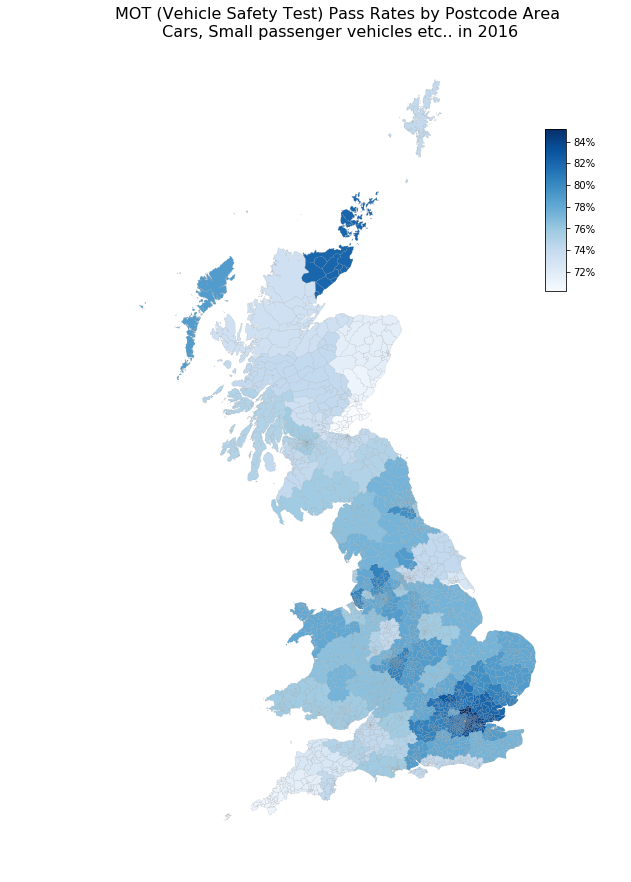

In [19]:
# Calculate percentage of cars that passed by Postcode Area
mot_data = calc_rates(summary_filter='test_result=="P"',
            column='test_result'
           )

# Create figure for plot and add subplot for choropleth
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111)
plt.axis('equal')
plt.axis('off')

# Choropleth appearance
intervals=20
cmap = 'Blues'

# Generate choropleth
choropleth(ax=ax,
           mot_data=mot_data,
           column='rate',
           intervals=intervals,
           cmap=cmap
           )

# Title
plt.title('MOT (Vehicle Safety Test) Pass Rates by Postcode Area\n Cars, Small passenger vehicles etc.. in 2016',
          fontdict={'fontsize':16})

# Calculate range for colorbar
min_value, max_value = scale_required(mot_data['rate'], intervals)

# Add axes for colorbar
cbax = fig.add_axes([0.8, 0.65, 0.03, 0.15]) 
# Create colorbar
colorbar(ax=cbax,
         min_value=min_value,
         max_value=max_value,
         intervals=intervals,
         percent=True,
         cmap=cmap
        )

plt.show()

There does appear to be some significant regional variation in MOT pass rates. This is not surprising given the diversity of the various regions of the UK.

## Age of vehicles having an MOT test by postcode area

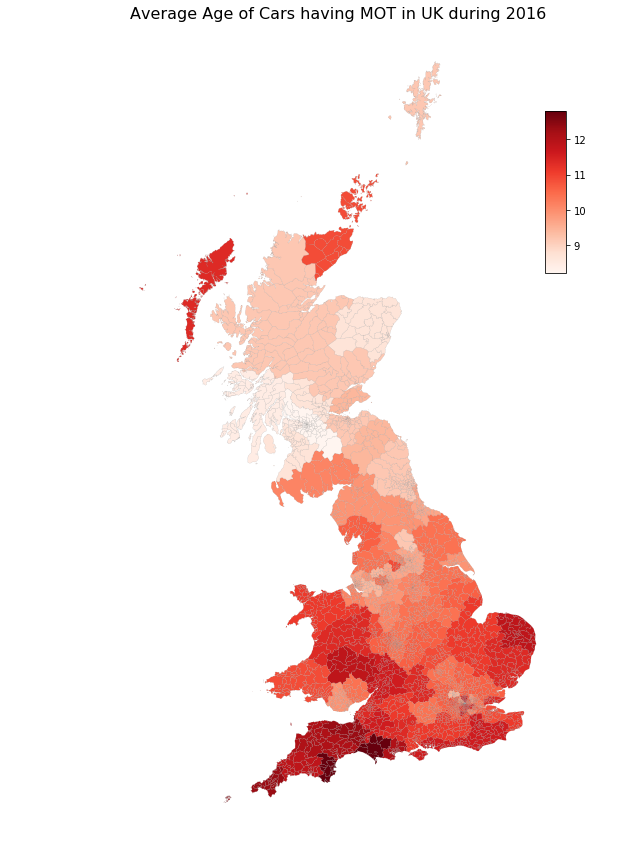

In [20]:
# Calculate mean age of vehicles having a MOT by postcode area
mot_age  = mot_results.groupby('postcode_area')[['age']].mean()
mot_age = mot_age.reset_index()

# Create figure for plot and add subplot for choropleth
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111)
plt.axis('equal')
plt.axis('off')

# Choropleth appearance
intervals=20
cmap='Reds'

# Generate choropleth
choropleth(ax=ax,
           mot_data=mot_age,
           column='age',
           intervals=intervals,
           cmap=cmap
           )

# Title
plt.title('Average Age of Cars having MOT in UK during 2016',
          fontdict={'fontsize':16})

# Calculate range for colorbar
min_value, max_value = scale_required(mot_age['age'], intervals)

# Add axes for colorbar
cbax = fig.add_axes([0.8, 0.65, 0.03, 0.15]) 
# Create colorbar
colorbar(ax=cbax,
         min_value=min_value,
         max_value=max_value,
         intervals=intervals,
         percent=False,
         cmap=cmap
        )

plt.show()

While this is only the *age of vehicles having an MOT*, not all vehicles. It is an indicator of vehicles ages in the various regions. Urban areas tend to have younger vehicles (having an MOT test).

However, the younger age of cars have an MOT in Scotland was a surprising result for me at first. This suggested further investigation. So in the next plot, I have compared MOT pass rates conditioned on vehicle age.

### MOT pass rates by postcode area and age of vehicle

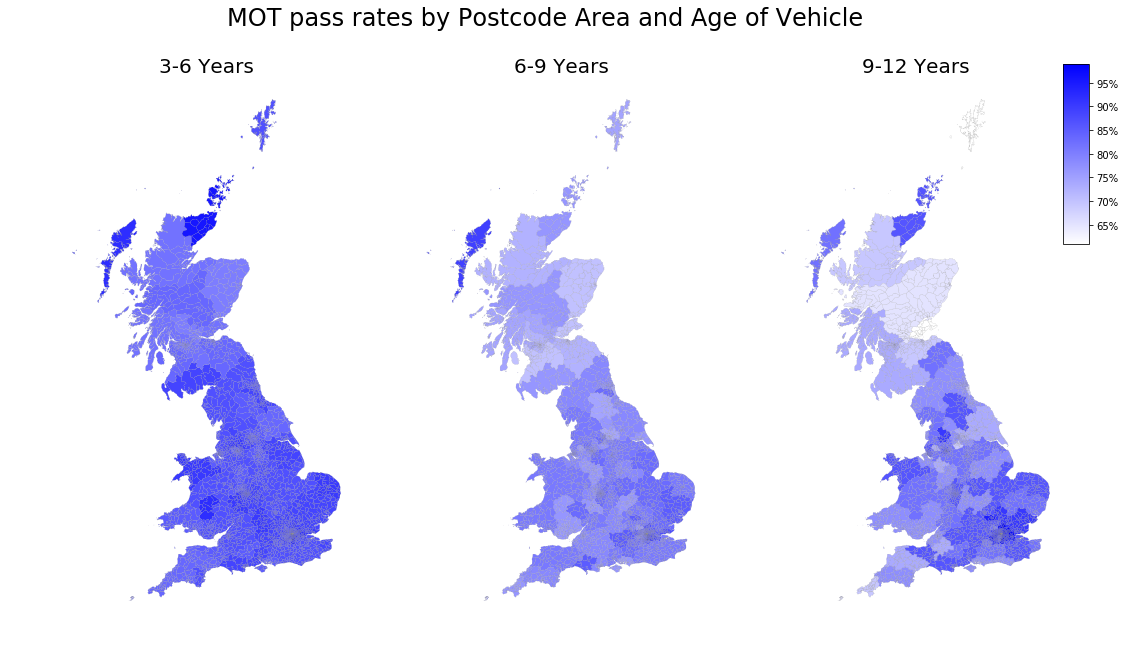

In [21]:
# Interval for choropleth
intervals = 20

# Colour scale to be used across all subplots
st_cols = [1,1,1]
end_cols = [0,0,1]

# Create figure for plot and add subplot for choropleth
fig = plt.figure(figsize=(18,10))
fig.suptitle("MOT pass rates by Postcode Area and Age of Vehicle", fontsize=24)

# Calculate pass rates for cars 3-6 years
mot_data_1 = calc_rates(results_filter="age > 3 and age < 6",
            summary_filter='test_result=="P"',
            column='test_result'
           )

# Calculate range for colorscale of subplot
min_rate_1, max_rate_1 = scale_required(mot_data_1['rate'], intervals)

# Calculate pass rates for cars 6-9 years
mot_data_2 = calc_rates(results_filter="age > 6 and age < 9",
            summary_filter='test_result=="P"',
            column='test_result'
           )

# Calculate range for colorscale of subplot
min_rate_2, max_rate_2 = scale_required(mot_data_2['rate'], intervals)

# Calculate pass rates for cars 9-12 years
mot_data_3 = calc_rates(results_filter="age > 9 and age < 12",
            summary_filter='test_result=="P"',
            column='test_result'
           )

# Calculate range for colorscale of subplot
min_rate_3, max_rate_3 = scale_required(mot_data_3['rate'], intervals)

# Find common range
min_scale = min(min_rate_1, min_rate_2, min_rate_3)
max_scale = max(max_rate_1, max_rate_2, max_rate_3)

# 1st Map
sub_choropleth(mot_data_1, min_rate_1, max_rate_1, min_scale, max_scale, fig, 131, '3-6 Years')

# 2nd map
sub_choropleth(mot_data_2, min_rate_2, max_rate_2, min_scale, max_scale, fig, 132, '6-9 Years')

# 3rd Map
sub_choropleth(mot_data_3, min_rate_3, max_rate_3, min_scale, max_scale, fig, 133, '9-12 Years')

# Color bar scale using full range across all maps
cmap = custom_cmap(min_scale, max_scale, min_scale, max_scale, st_cols, end_cols)
# Add axes for colorbar
cbax = fig.add_axes([0.9, 0.65, 0.02, 0.25]) 
colorbar(cbax, min_scale, max_scale, intervals, percent=True, cmap=cmap)

plt.show()

Vehicles that are 3-6 years old, seem to have a fairly consistent pass rate across the country.

There is some regional variation for vehicles that are 6-9 years old. With vehicles in Scotland having a slightly lower pass rate.

This difference becomes more pronounced for vehicles that are 9-12 years old.

One possible explanation for this is that Scotland experiences colder conditions than the rest of the UK, requiring more frequent gritting of the roads. The salt in the grit is known to cause rust.

## Diesel Cars
As the data this is based on is only for cars having an MOT, the following is only an approximate indicator of the numbers of Diesel cars in various parts of the UK.

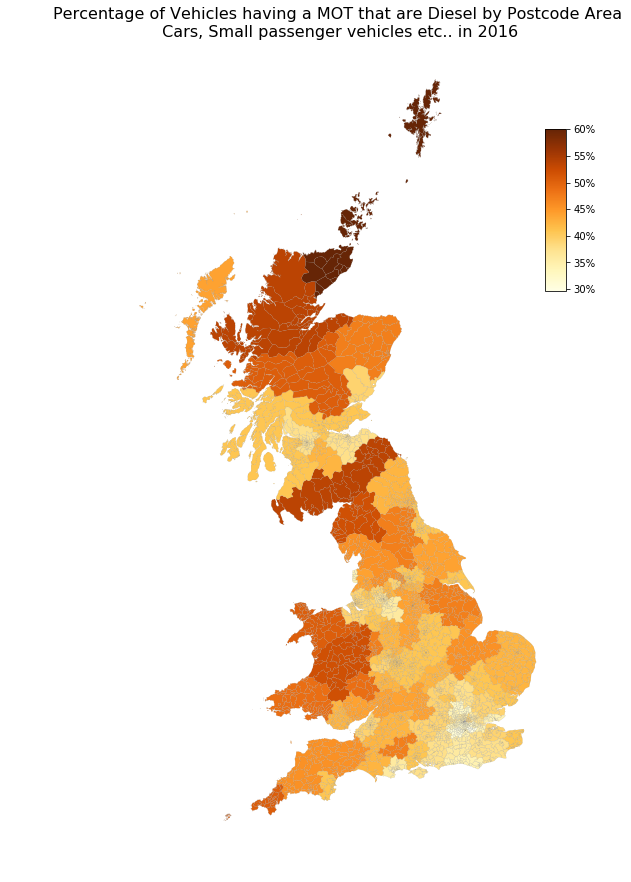

In [22]:
# Calculate percentages of vehicles having an MOT that are diesel
mot_data = calc_rates(summary_filter='fuel_type=="DI"',
            column='fuel_type'
           )

# Create figure for plot and add subplot for choropleth
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111)
plt.axis('equal')
plt.axis('off')

# Choropleth appearance
intervals=20
cmap = 'YlOrBr'

# Generate choropleth
choropleth(ax=ax,
           mot_data=mot_data,
           column='rate',
           intervals=intervals,
           cmap=cmap
           )

# Title
plt.title('Percentage of Vehicles having a MOT that are Diesel by Postcode Area\n Cars, Small passenger vehicles etc.. in 2016',
          fontdict={'fontsize':16})

# Calculate range for colorbar
min_value, max_value = scale_required(mot_data['rate'], intervals)

# Add axes for colorbar
cbax = fig.add_axes([0.8, 0.65, 0.03, 0.15]) 
# Create colorbar
colorbar(ax=cbax,
         min_value=min_value,
         max_value=max_value,
         intervals=intervals,
         percent=True,
         cmap=cmap
        )

plt.show()

There is a clear regional variation. Areas having higher numbers of Diesel vehicles tend to be rural (Mid Wales, the Highlands etc..).

## Electric, Fuel Cell and Hybrid Vehicles
As the data this is based on is only for cars having an MOT, the following is only an approximate indicator of the numbers of Electric, Fuel Cell or Hybrid cars.

As numbers across the UK were very low, I have concentrated on London which had the highest numbers.

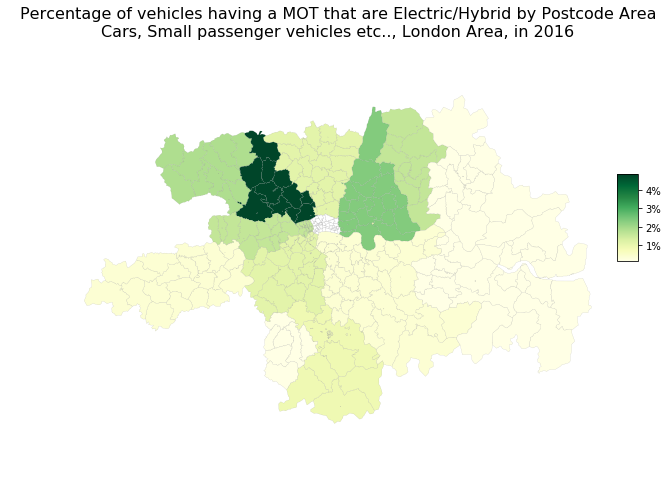

In [23]:
# Calculate percentages of vehicles having an MOT that are Electric or Hybrid
mot_data = calc_rates(summary_filter='fuel_type=="G"',
            column='fuel_type'
           )

# Create figure for plot and add subplot for choropleth
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.axis('equal')
plt.axis('off')

# Choropleth appearance
intervals=20
cmap = 'YlGn'

# Generate choropleth
choropleth(ax=ax,
           mot_data=mot_data,
           column='rate',
           region='London',
           intervals=intervals,
           cmap=cmap
           )

# Title
plt.title('''Percentage of vehicles having a MOT that are Electric/Hybrid by Postcode Area
Cars, Small passenger vehicles etc.., London Area, in 2016''',
          fontdict={'fontsize':16})


# Calculate range for colorbar
min_value, max_value = scale_required(mot_data['rate'], intervals)

# Add axes for colorbar
cbax = fig.add_axes([0.9,0.5, 0.03, 0.15]) 
# Create colorbar
colorbar(ax=cbax,
         min_value=min_value,
         max_value=max_value,
         intervals=intervals,
         percent=True,
         cmap=cmap
        )

plt.show()

Cars have to be 3 years old before they have there 1st MOT. So this plot does not show current rates of Electric/Hybird vehicles. However it does indicate emerging patterns. Highest rates occur in West London, which is fairly affluent.